<a href="https://colab.research.google.com/github/Sahanaka/Simple_vid_classifer/blob/main/VideoClassification_ActivityRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Video Classification and Human Activity Recognition**
In this notebook we shall find ways to process video data and classify them to detect human activities

**Dataset used : UCF 50**

**Setps**

* **Step 1: Download and Extract the Dataset**
* **Step 2: Visualize the Data with its Labels**
* **Step 3: Read and Preprocess the Dataset**
* **Step 4: Split the Data into Train and Test Set**
* **Step 5: Construct the Model**
* **Step 6: Compile and Train the Model**
* **Step 7: Plot Model’s Loss and Accuracy Curves**
* **Step 8: Make Predictions with the Model**
* **Step 9: Using Single-Frame CNN Method**

We have already downloaded the dataset to google drive. Mount the drive to use the data set. Also check for the possibility of using Onedrive.

## **Setup**

In [1]:
!pip install pafy youtube-dl moviepy

In [2]:
# Packages and imports
import os
import cv2
import math
import pafy
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from moviepy.editor import *
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [3]:
# ENV setup
seed_constant = 23
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Sanity to check to see if the drive is mounted
!ls /content/drive/MyDrive/UCF50/

BaseballPitch  HorseRiding     PlayingPiano	   Skiing
Basketball     HulaHoop        PlayingTabla	   Skijet
BenchPress     JavelinThrow    PlayingViolin	   SoccerJuggling
Biking	       JugglingBalls   PoleVault	   Swing
Billiards      JumpingJack     PommelHorse	   TaiChi
BreastStroke   JumpRope        PullUps		   TennisSwing
CleanAndJerk   Kayaking        Punch		   ThrowDiscus
Diving	       Lunges	       PushUps		   TrampolineJumping
Drumming       MilitaryParade  RockClimbingIndoor  VolleyballSpiking
Fencing        Mixing	       RopeClimbing	   WalkingWithDog
GolfSwing      Nunchucks       Rowing		   YoYo
HighJump       PizzaTossing    SalsaSpin
HorseRace      PlayingGuitar   SkateBoarding


## **Step 2: Visualize the Data with its Labels**

In [6]:
BASE_DIR = '/content/drive/MyDrive/UCF50/'

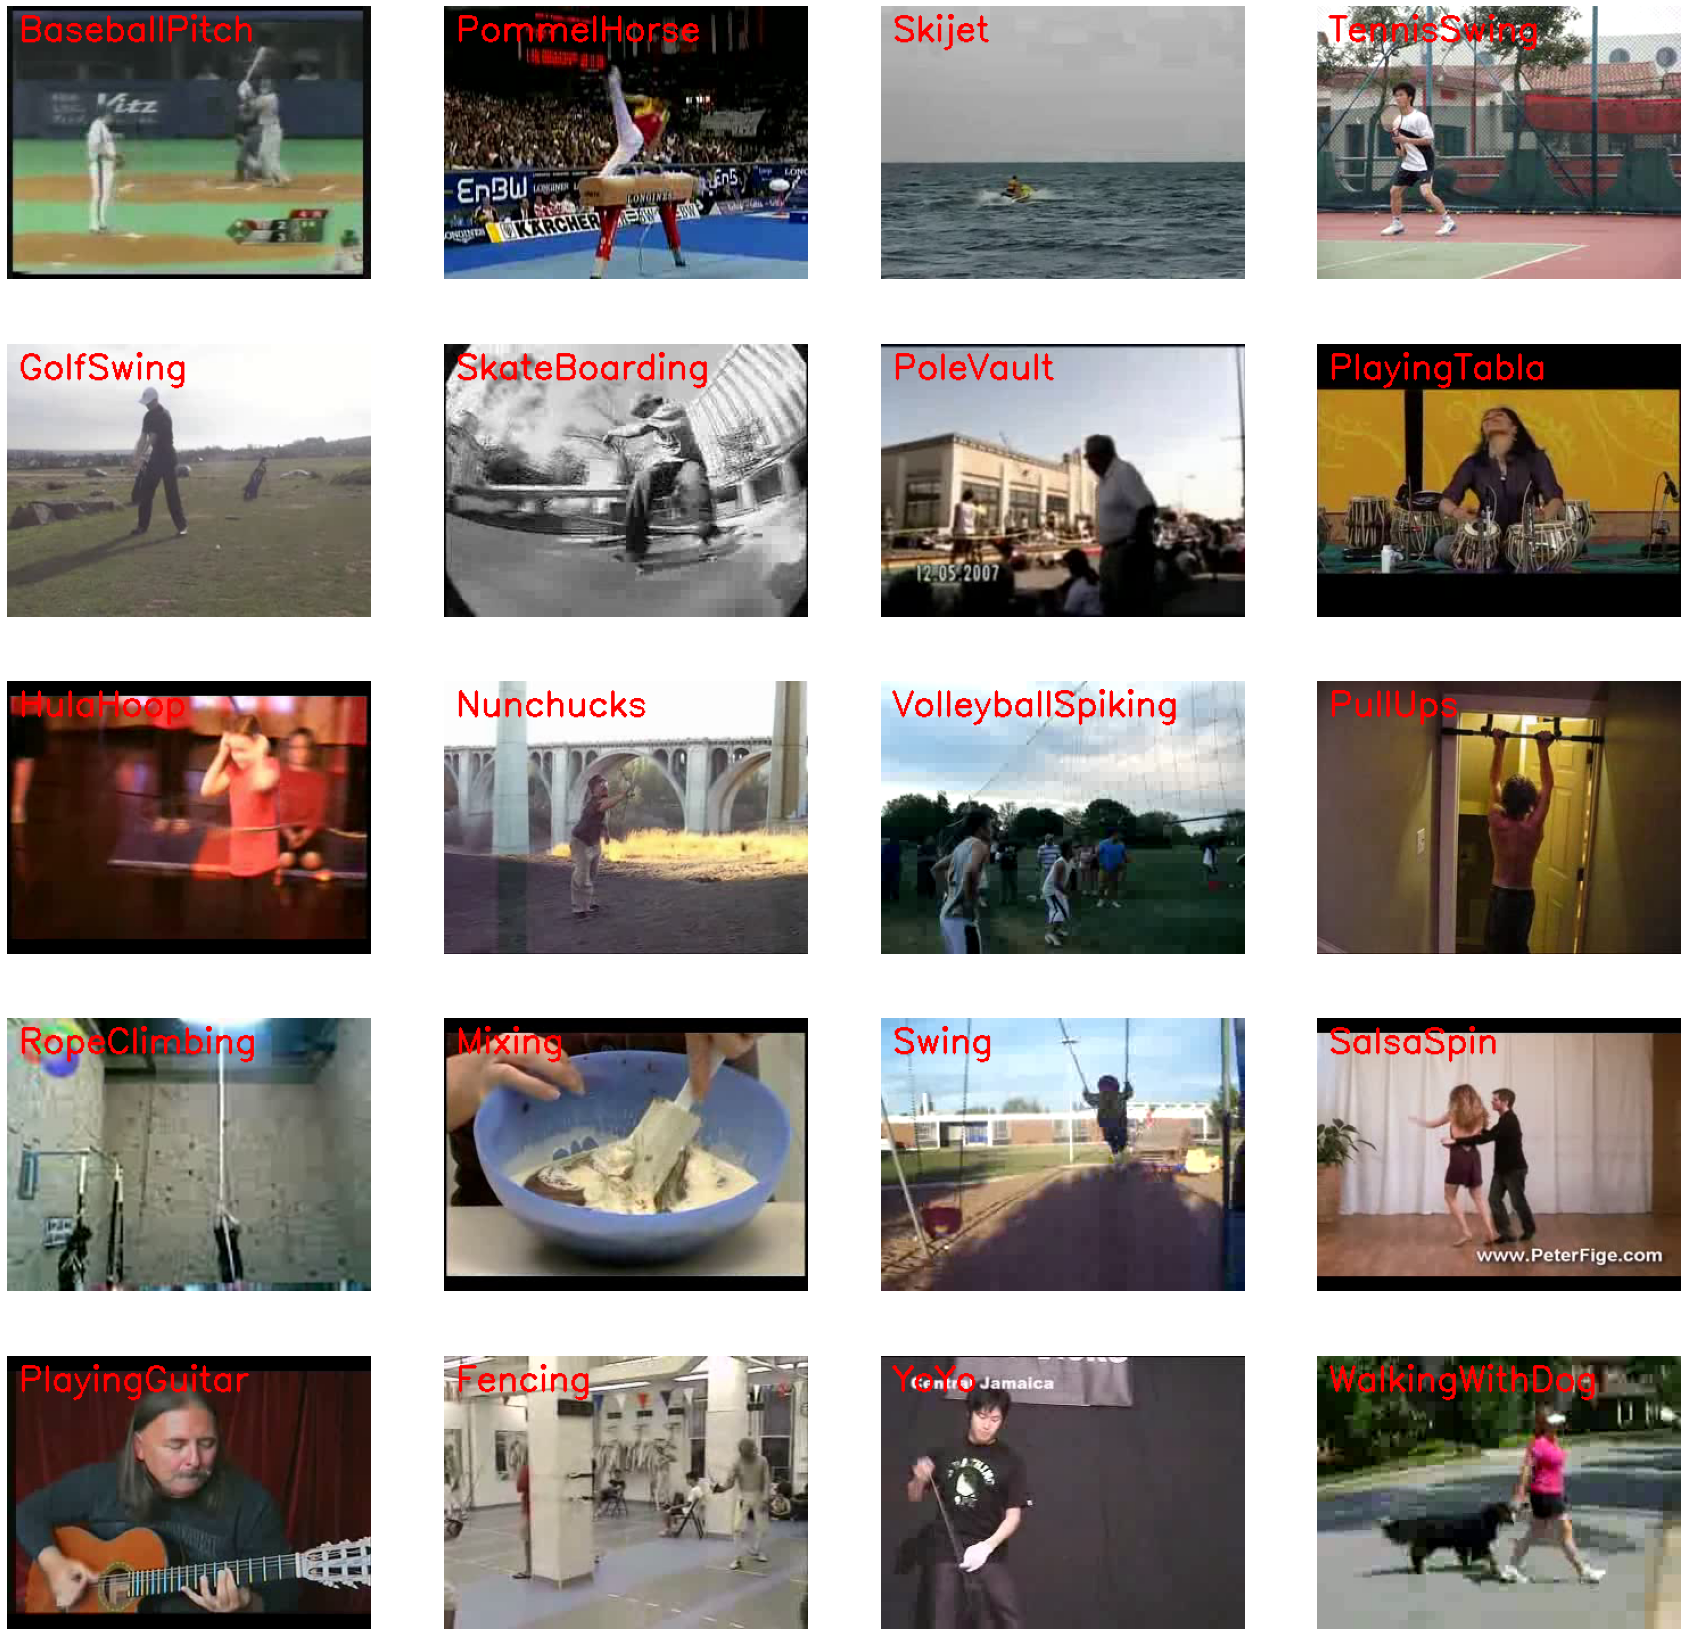

In [7]:
# Matplotlib figure
plt.figure(figsize = (30, 30))

all_classes_names = os.listdir(BASE_DIR)

# Generate a random sample of images each time the cell runs
random_range = random.sample(range(len(all_classes_names)), 20)

# Iterating through all the random samples
for counter, random_index in enumerate(random_range, 1):
    # Getting Class Name using Random Index
    selected_class_Name = all_classes_names[random_index]

    # Getting a list of all the video files present in a Class Directory
    video_files_names_list = os.listdir(f'{BASE_DIR}/{selected_class_Name}')

    # Randomly selecting a video file
    selected_video_file_name = random.choice(video_files_names_list)

    # Reading the Video File Using the Video Capture
    video_reader = cv2.VideoCapture(f'{BASE_DIR}/{selected_class_Name}/{selected_video_file_name}')
     
    # Reading The First Frame of the Video File
    _, bgr_frame = video_reader.read()
 
    # Closing the VideoCapture object and releasing all resources.
    video_reader.release()
 
    # Converting the BGR Frame to RGB Frame
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
 
    # Adding The Class Name Text on top of the Video Frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
     
    # Assigning the Frame to a specific position of a subplot
    plt.subplot(5, 4, counter)
    plt.imshow(rgb_frame)
    plt.axis('off')



## **Step 3: Read and Preprocess the Dataset**

We are going to train using the following 4 classes
* Tai chi
* Horse riding
* Swinging
* Walking with a dog

In [8]:
image_height, image_width = 64, 64 # 64 x 64 image
max_images_per_class = 8000

dataset_directory = BASE_DIR
classes_list = ["WalkingWithDog", "TaiChi", "Swing", "HorseRace"]

model_output_size = len(classes_list)
model_output_size

4

The following function takes a video file path as input. It then reads the video file frame by frame, resizes each frame, normalizes the resized frame, appends the normalized frame into a list, and then finally returns that list

In [9]:
def frames_extraction(video_path):
  frames_list = [] # To store video frames

  video_reader = cv2.VideoCapture(video_path) # Using CV2

  # Iterate through video frames:
  while True:
    success, frame = video_reader.read() # Reading frame from the video

    if not success:
      break
    
    resized_frame = cv2.resize(frame, (image_height, image_width)) # Resize the frame
    normalized_frame = resized_frame / 255 # Normalize into 0 - 1

    frames_list.append(normalized_frame) # Append to the frames list
   
  video_reader.release() # Close the video reader

  return frames_list

  

In [10]:
frames_extraction(BASE_DIR)

[]

The following function uses the frame_extraction() function above and creates our final preprocessed dataset

In [11]:
def create_dataset():
  temp_features = []
  features = []
  labels = []

  for class_index, class_name in enumerate(classes_list):
    print(f'Extracting data from class: { class_name }')
    
    files_list = os.listdir(os.path.join(dataset_directory, class_name)) # Files list in a directory

    for file_name in files_list:
      video_path = os.path.join(dataset_directory, class_name, file_name) # File path

      frames = frames_extraction(video_path) 

      temp_features.extend(frames) 

    features.extend(random.sample(temp_features, max_images_per_class))
    labels.extend([class_index] * max_images_per_class)

    temp_features.clear() # Clear the list for the next iteration

  features = np.array(features)
  labels = np.array(labels)

  return features, labels

In [12]:
features, labels = create_dataset()

Extracting data from class: WalkingWithDog
Extracting data from class: TaiChi
Extracting data from class: Swing
Extracting data from class: HorseRace


In [13]:
print(len(features))
print(len(labels))

32000
32000


In [15]:
one_hot_encoded_labels = to_categorical(labels)
one_hot_encoded_labels

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

## **Step 4: Split the Data into Train and Test Sets**

In [16]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, 
                                                                            test_size=0.2, shuffle=True, random_state=seed_constant)

## **Step 5: Construct the Model**

In [23]:
def create_model():
  model = Sequential() # Sequential model
  
  model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', input_shape=(image_height, image_width, 3)))
  model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(GlobalAveragePooling2D())
  model.add(Dense(256, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dense(model_output_size, activation='softmax'))

  print(model.summary())
  return model

model = create_model()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 62, 62, 64)        1792      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
batch_normalization_6 (Batch (None, 60, 60, 64)        256       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
global_average_pooling2d_3 ( (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               16640     
_________________________________________________________________
batch_normalization_7 (Batch (None, 256)              

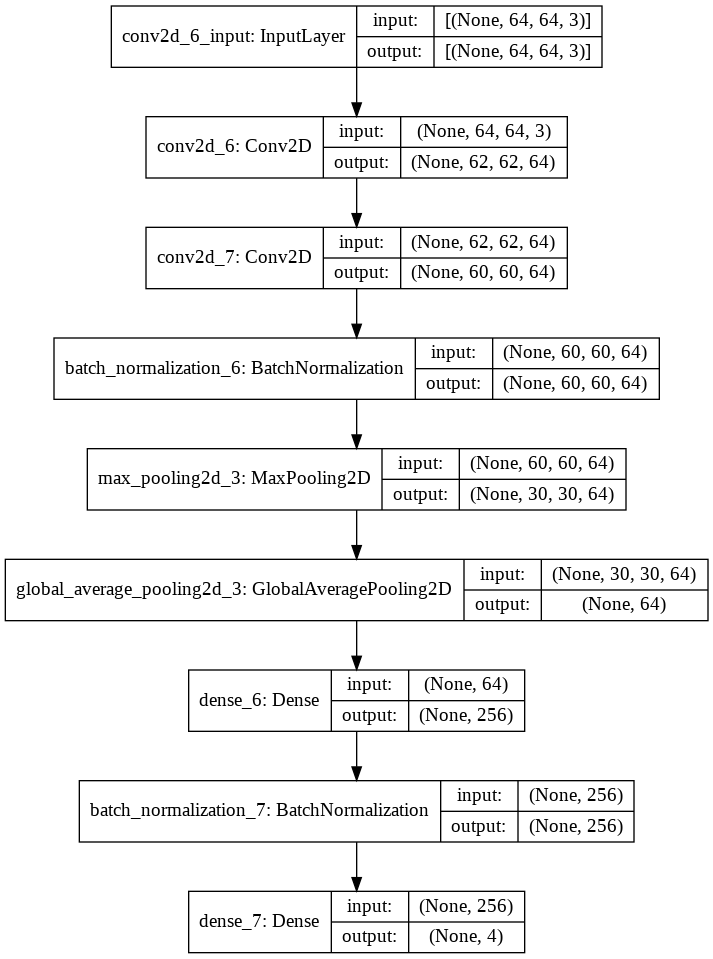

In [24]:
plot_model(model, to_file='model_structure_plot.png', show_shapes=True, show_layer_names=True)

## **Step 6: Compile and Train the Model**

In [25]:
# Early stopping call back
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=15,
                                        mode='min', restore_best_weights=True)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x=features_train, y=labels_train, epochs=50, batch_size=4, 
                    shuffle=True, validation_split=0.2, callbacks=[early_stopping_callback])

Epoch 1/50
5120/5120 [==============================] - 592s 115ms/step - loss: 0.8607 - accuracy: 0.6568 - val_loss: 0.5496 - val_accuracy: 0.8484
Epoch 2/50
5120/5120 [==============================] - 587s 115ms/step - loss: 0.5131 - accuracy: 0.8093 - val_loss: 1.7123 - val_accuracy: 0.6357
Epoch 3/50
5120/5120 [==============================] - 588s 115ms/step - loss: 0.3851 - accuracy: 0.8635 - val_loss: 0.3330 - val_accuracy: 0.9201
Epoch 4/50
5120/5120 [==============================] - 596s 116ms/step - loss: 0.3120 - accuracy: 0.8923 - val_loss: 0.3024 - val_accuracy: 0.9074
Epoch 5/50
5120/5120 [==============================] - 595s 116ms/step - loss: 0.2801 - accuracy: 0.9063 - val_loss: 1.0211 - val_accuracy: 0.7412
Epoch 6/50
5120/5120 [==============================] - 591s 115ms/step - loss: 0.2441 - accuracy: 0.9185 - val_loss: 0.4062 - val_accuracy: 0.9348
Epoch 7/50
5120/5120 [==============================] - 592s 116ms/step - loss: 0.2352 - accuracy: 0.9219 - val_

### Evaluating the model

In [27]:
model.evaluate(features_test, labels_test)

200/200 [==============================] - 39s 193ms/step - loss: 0.1090 - accuracy: 0.9647


[0.1090073361992836, 0.9646875262260437]

### Saving the model

In [32]:
model_name = 'CNN_Model'
model.save(model_name)

INFO:tensorflow:Assets written to: CNN_Model/assets


In [33]:
!mkdir -p saved_model
model.save('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model/assets


In [35]:
# saved to drive
SAVED_DIR = '/content/drive/MyDrive/'
model.save(f'{ SAVED_DIR }/my_model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive//my_model/assets


## **Step 7: Plot Model’s Loss and Accuracy Curves**

In [29]:
	def plot_metric(metric_name_1, metric_name_2, plot_name):
  metric_value_1 = history.history[metric_name_1] # Get Metric values using metric names as identifiers
  metric_value_2 = history.history[metric_name_2]
  epochs = range(len(metric_value_1))
  plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
  plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)
  plt.title(str(plot_name))
  plt.legend()


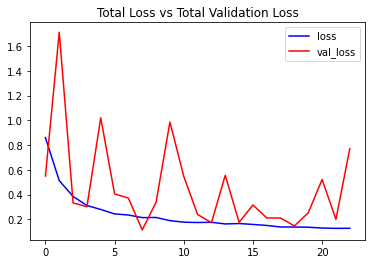

In [30]:
plot_metric('loss', 'val_loss', 'Total Loss vs Total Validation Loss')

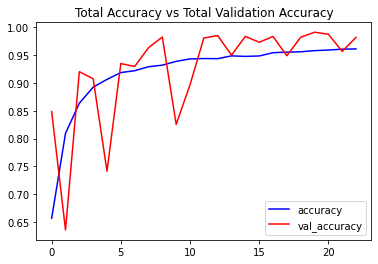

In [31]:
plot_metric('accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

## **Step 8: Make Predictions with the Model:**